In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

from utils import mnist, plot_graphs, plot_mnist
import numpy as np

%matplotlib inline

In [2]:
mnist_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
           ])
train_loader, valid_loader, test_loader = mnist(valid=10000, transform=mnist_transform, batch_size=64)

In [3]:
class Encoder(nn.Module):
    def __init__(self, latent_size=10):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, latent_size)
    
    def forward(self, x):
        x = F.tanh(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        return x
    
class Decoder(nn.Module):
    def __init__(self, latent_size=10):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_size, 128)
        self.fc2 = nn.Linear(128, 28*28)
    
    def forward(self, x):
        x = F.tanh(self.fc1(x))
        x = F.tanh(self.fc2(x))
        return x

In [4]:
class Net(nn.Module):
    def __init__(self, latent_size=10, loss_fn=F.mse_loss, lr=1e-4, l2=0.):
        super(Net, self).__init__()
        self.latent_size = latent_size
        self.E = Encoder(latent_size)
        self.D = Decoder(latent_size)
        self.loss_fn = loss_fn
        self._rho_loss = None
        self._loss = 0.    
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
             
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        h = self.E(x)
        self.data_rho = h.mean(0)
        out = self.D(h)
        return out
    
    def decode(self, h):
        with torch.no_grad():
            return self.D(h)
    
    def rho_loss(self, rho, size_average=True):
        """
        D_KL(P||Q) = sum(p*log(p/q)) = -sum(p*log(q/p)) = -p*log(q/p) - (1-p)log((1-q)/(1-p))
        """
        dkl = - torch.log(self.data_rho) * rho - torch.log(1-self.data_rho) * (1-rho)
        if size_average:
            self._rho_loss = dkl.mean()
        else:
            self._rho_loss = dkl.sum()
        return self._rho_loss
    
    def loss(self, x, target, **kwargs):
        target = target.view(-1, 28*28)
        self._loss = self.loss_fn(x, target, **kwargs)
        return self._loss
   
   

In [5]:
models = {'16': Net(16), '32': Net(32), '64': Net(64)}
rho = 0.05
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [17]:
def train(epoch, models, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, _) in enumerate(train_loader):
        for model in models.values():
            model.optim.zero_grad()
            output = model(data)
            rho_loss = model.rho_loss(rho)
            loss = model.loss(output, data) + rho_loss
            loss.backward()
            model.optim.step()
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        if log is not None:
            for k in models:
                log[k].append((models[k]._loss, models[k]._rho_loss))
        print(line + losses)

In [18]:
avg_lambda = lambda l: 'loss: {:.4f}'.format(l)
rho_lambda = lambda p: 'pho_loss: {:.4f}'.format(p)
line = lambda i, l, p: '{}: '.format(i) + avg_lambda(l) + '\t' + rho_lambda(p)
    
def test(models, loader, log=None):
    test_size = len(loader.sampler)


    test_loss = {k: 0. for k in models}
    pho_loss = {k: 0. for k in models}
    with torch.no_grad():
        for data, _ in loader:
            output = {k: m(data) for k, m in models.items()}
            for k, m in models.items():
                test_loss[k] += m.loss(output[k], data, size_average=False).item() # sum up batch loss
                pho_loss[k] += m.rho_loss(rho, size_average=False).item()
    
    for k in models:
        test_loss[k] /= (test_size * 784)
        pho_loss[k] /= (test_size * models[k].latent_size)
        if log is not None:
            log[k].append((test_loss[k], pho_loss[k]))
    
    lines = '\n'.join([line(k, test_loss[k], pho_loss[k]) for k in models]) + '\n'
    report = 'Test set:\n' + lines        
    print(report)

In [19]:
for epoch in range(1, 21):
    for model in models.values():
        model.train()
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test(models, valid_loader, test_log)

Train Epoch: 1 [0/50000 (0%)]	Losses 16: 0.955864 32: 0.948106 64: 0.956732
Train Epoch: 1 [12800/50000 (26%)]	Losses 16: 0.507571 32: 0.419571 64: 0.359906
Train Epoch: 1 [25600/50000 (51%)]	Losses 16: 0.326881 32: 0.307132 64: 0.295482
Train Epoch: 1 [38400/50000 (77%)]	Losses 16: 0.290416 32: 0.282486 64: 0.276205
Train Epoch: 1 [12512/50000 (100%)]	Losses 16: 0.243384 32: 0.237555 64: 0.233156
Test set:
16: loss: 0.2813	pho_loss: 0.0032
32: loss: 0.2770	pho_loss: 0.0033
64: loss: 0.2730	pho_loss: 0.0033

Train Epoch: 2 [0/50000 (0%)]	Losses 16: 0.292312 32: 0.288262 64: 0.284145
Train Epoch: 2 [12800/50000 (26%)]	Losses 16: 0.283725 32: 0.280914 64: 0.278339
Train Epoch: 2 [25600/50000 (51%)]	Losses 16: 0.270020 32: 0.267240 64: 0.266165
Train Epoch: 2 [38400/50000 (77%)]	Losses 16: 0.270357 32: 0.266777 64: 0.267367
Train Epoch: 2 [12512/50000 (100%)]	Losses 16: 0.230018 32: 0.225207 64: 0.229105
Test set:
16: loss: 0.2616	pho_loss: 0.0031
32: loss: 0.2581	pho_loss: 0.0031
64: los

Train Epoch: 17 [12800/50000 (26%)]	Losses 16: 0.135853 32: 0.117434 64: 0.109805
Train Epoch: 17 [25600/50000 (51%)]	Losses 16: 0.137364 32: 0.116892 64: 0.111352
Train Epoch: 17 [38400/50000 (77%)]	Losses 16: 0.147314 32: 0.125167 64: 0.117112
Train Epoch: 17 [12512/50000 (100%)]	Losses 16: 0.162652 32: 0.139450 64: 0.131290
Test set:
16: loss: 0.1419	pho_loss: 0.0032
32: loss: 0.1199	pho_loss: 0.0032
64: loss: 0.1128	pho_loss: 0.0031

Train Epoch: 18 [0/50000 (0%)]	Losses 16: 0.140161 32: 0.119108 64: 0.112689
Train Epoch: 18 [12800/50000 (26%)]	Losses 16: 0.146971 32: 0.123730 64: 0.116544
Train Epoch: 18 [25600/50000 (51%)]	Losses 16: 0.132891 32: 0.111794 64: 0.105958
Train Epoch: 18 [38400/50000 (77%)]	Losses 16: 0.126605 32: 0.105735 64: 0.099215
Train Epoch: 18 [12512/50000 (100%)]	Losses 16: 0.118234 32: 0.098515 64: 0.096589
Test set:
16: loss: 0.1371	pho_loss: 0.0032
32: loss: 0.1159	pho_loss: 0.0032
64: loss: 0.1078	pho_loss: 0.0031

Train Epoch: 19 [0/50000 (0%)]	Losses 1

In [20]:
torch.save(models['64'], './model_64_kl_gn1')


/Users/aleksey/anaconda3/envs/otus-dl-engineer/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/Users/aleksey/anaconda3/envs/otus-dl-engineer/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type Encoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/Users/aleksey/anaconda3/envs/otus-dl-engineer/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type Decoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


### Вывод результатов

In [6]:
model = torch.load('./model_64_kl_gn1')

In [7]:
data, _ = next(iter(test_loader))
output = model(data)
to_plot = output.view(-1, 1, 28, 28).clamp(0, 1).data.numpy()
decoded = model.decode(torch.eye(64))
dec_to_plot = ((decoded.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.numpy()
with torch.no_grad():
    encoded = model.E(data.view(-1, 28*28))
    print((encoded > 0.2).sum(1))
    encoded[encoded < 0.2] = 0.
    decoded_f = model.decode(encoded)
    f_to_plot = ((decoded_f.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.numpy()

tensor([  7,   6,   3,   7,   5,   5,   2,   4,   3,   4,   5,   0,
          6,   6,   5,   3,   5,   4,   6,   3,   9,   8,   2,   4,
          3,   4,   8,   4,   6,   6,   4,   6,   8,   1,   5,   3,
          3,   5,   1,   6,   5,   4,   4,   1,   3,   4,   6,   3,
          5,   4,   4,   2,   5,   4,   3,   5,   4,   3,   6,   5,
         11,   1,   1,   2])


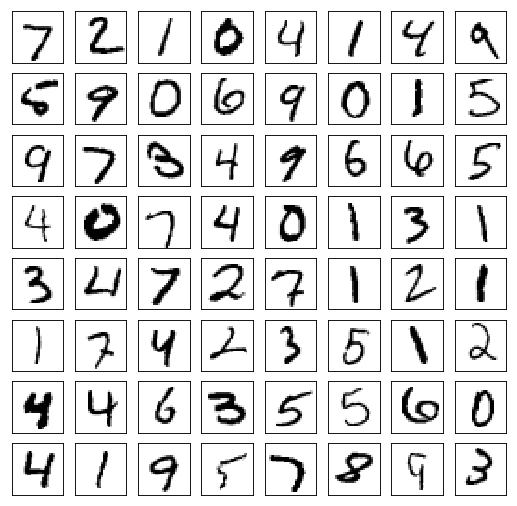

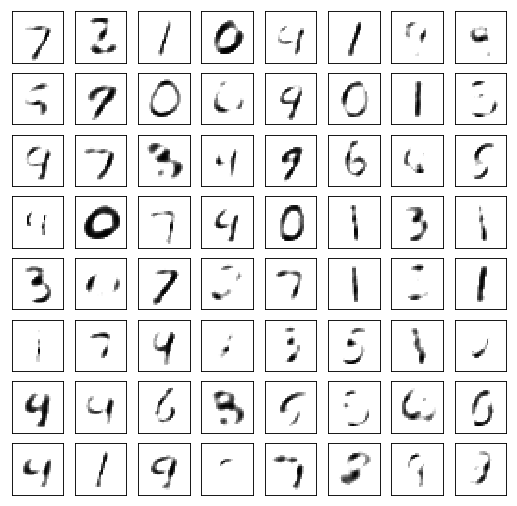

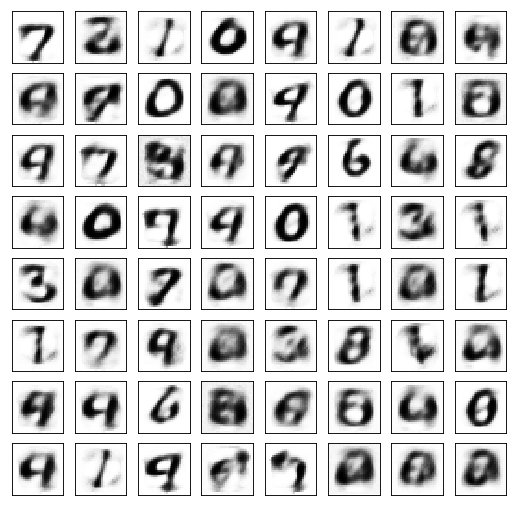

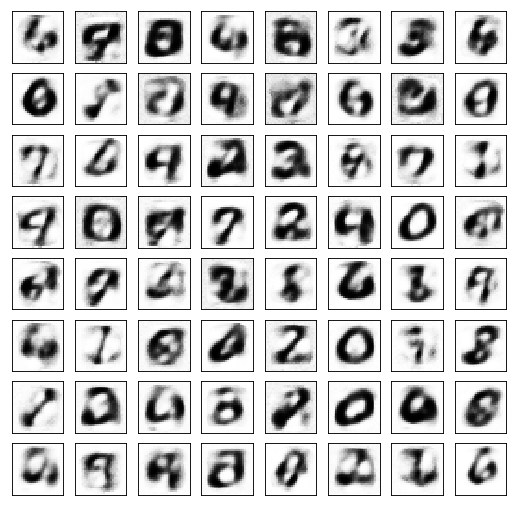

In [8]:
plot_mnist(data.data.numpy(), (8, 8))
plot_mnist(to_plot, (8, 8))
plot_mnist(f_to_plot, (8, 8))
plot_mnist(dec_to_plot, (8, 8))

### Генерация новых изображений


In [40]:
from torch.autograd import Variable

def generate_image(img):
    
    gen_img_par = Variable(img, requires_grad=True)
    latent_vector = torch.eye(64)
    loss_stats = []
    
    gen_optim = optim.Adam([gen_img_par], lr=1e-2, weight_decay=0.)

    for i in range(1, 500001):  
        
        target = model.E(gen_img_par.view(-1, 28*28))
        
        gen_optim.zero_grad()
        loss = F.mse_loss(target, latent_vector)    
        loss.backward()                   
        gen_optim.step()
        
        if i % 2000 == 0:    
            print ("Iteration {}: loss={}".format(i,loss))
            ls = loss.detach().numpy()            
            loss_stats.append(ls)
                        
            if len(loss_stats) > 5:    
                if ls > loss_stats[-2] and ls > loss_stats[-3]:
                    print ("Loss is rising .. stop")
                    break

        if i % 40000 == 0:
            to_plot = gen_img_par.view(-1, 1, 28, 28).clamp(0, 1).data.numpy()
            plot_mnist(to_plot, (8, 8))
                        
    return gen_img_par    

### Генерация изображений из батча

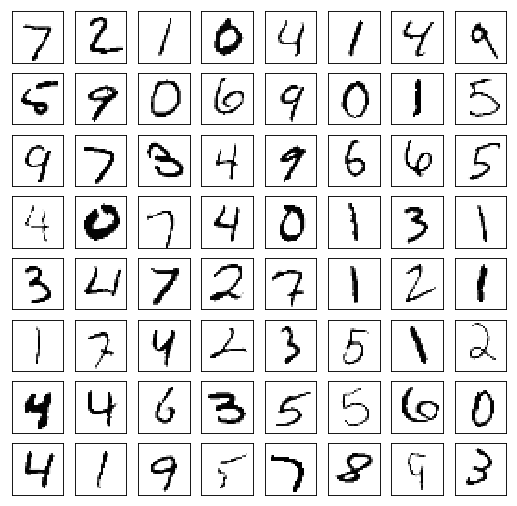

In [41]:
img, _ = next(iter(test_loader))
to_plot = img.view(-1, 1, 28, 28).clamp(0, 1).data.numpy()
plot_mnist(to_plot, (8, 8))

Iteration 2000: loss=0.0009022605954669416
Iteration 4000: loss=0.0008550045895390213
Iteration 6000: loss=0.0008417330682277679
Iteration 8000: loss=0.0008382442756555974
Iteration 10000: loss=0.0008352281292900443
Iteration 12000: loss=0.0008338711922988296
Iteration 14000: loss=0.0008322680951096117
Iteration 16000: loss=0.000831355107948184
Iteration 18000: loss=0.0008305338560603559
Iteration 20000: loss=0.0008304279763251543
Iteration 22000: loss=0.0008303912472911179
Iteration 24000: loss=0.0008303576614707708
Iteration 26000: loss=0.0008298114989884198
Iteration 28000: loss=0.0008291627163998783
Iteration 30000: loss=0.0008286819793283939
Iteration 32000: loss=0.0008282657945528626
Iteration 34000: loss=0.0008282530470751226
Iteration 36000: loss=0.0008282436174340546
Iteration 38000: loss=0.0008282343624159694
Iteration 40000: loss=0.0008282255148515105


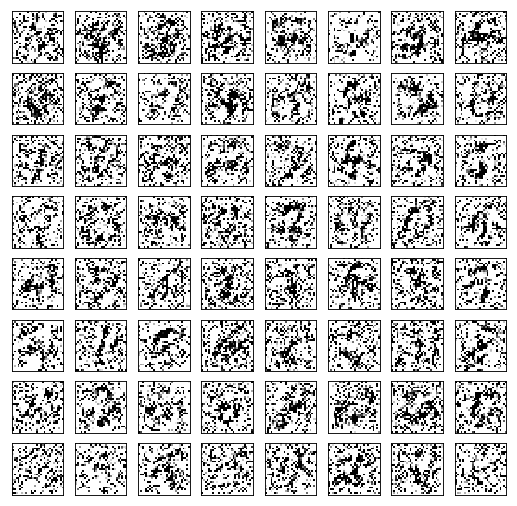

Iteration 42000: loss=0.0008281531045213342
Iteration 44000: loss=0.0008281468180939555
Iteration 46000: loss=0.000828127667773515
Iteration 48000: loss=0.0008281225454993546
Iteration 50000: loss=0.0008280880283564329
Iteration 52000: loss=0.0008280821493826807
Iteration 54000: loss=0.0008280783658847213
Iteration 56000: loss=0.0008280726615339518
Iteration 58000: loss=0.0008280689362436533
Iteration 60000: loss=0.000827954092528671
Iteration 62000: loss=0.0008276902372017503
Iteration 64000: loss=0.0008276664884760976
Iteration 66000: loss=0.0008276632870547473
Iteration 68000: loss=0.0008276404696516693
Iteration 70000: loss=0.0008275345317088068
Iteration 72000: loss=0.0008275321451947093
Iteration 74000: loss=0.0008275305735878646
Iteration 76000: loss=0.0008275280124507844
Iteration 78000: loss=0.0008275234722532332
Iteration 80000: loss=0.0008275183499790728


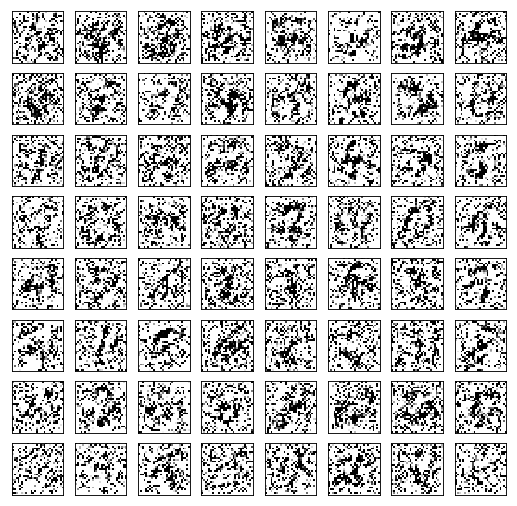

Iteration 82000: loss=0.0008275100262835622
Iteration 84000: loss=0.0008275066502392292
Iteration 86000: loss=0.0008275054860860109
Iteration 88000: loss=0.0008275032741948962
Iteration 90000: loss=0.0008275019354186952
Iteration 92000: loss=0.0008274980937130749
Iteration 94000: loss=0.0008267596131190658
Iteration 96000: loss=0.0008267506491392851
Iteration 98000: loss=0.0008267454686574638
Iteration 100000: loss=0.0008267449447885156
Iteration 102000: loss=0.000826744013465941
Iteration 104000: loss=0.0008267422090284526
Iteration 106000: loss=0.0008267373195849359
Iteration 108000: loss=0.0008267360972240567
Iteration 110000: loss=0.0008267359808087349
Iteration 112000: loss=0.0008267351659014821
Iteration 114000: loss=0.0008267348166555166
Iteration 116000: loss=0.000826733186841011
Iteration 118000: loss=0.0008267320226877928
Iteration 120000: loss=0.0008267309749498963


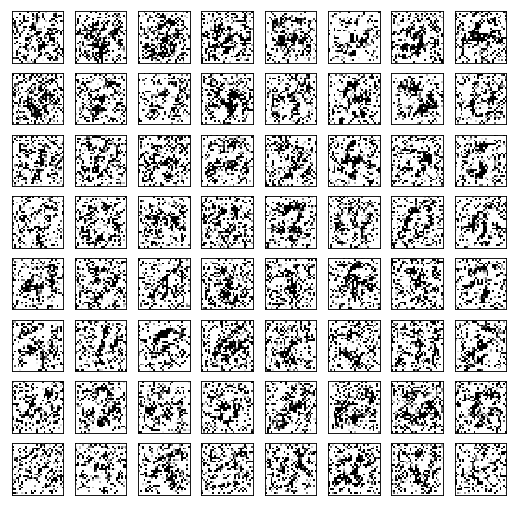

Iteration 122000: loss=0.0008267235825769603
Iteration 124000: loss=0.0008267230005003512
Iteration 126000: loss=0.0008267221855930984
Iteration 128000: loss=0.0008267216035164893
Iteration 130000: loss=0.0008267207886092365
Iteration 132000: loss=0.0008267204975709319
Iteration 134000: loss=0.000826719799079001
Iteration 136000: loss=0.00082671910058707
Iteration 138000: loss=0.0008266493096016347
Iteration 140000: loss=0.0008266480872407556
Iteration 142000: loss=0.0008266477379947901
Iteration 144000: loss=0.0008266471559181809
Iteration 146000: loss=0.0008264371426776052
Iteration 148000: loss=0.0008263819618150592
Iteration 150000: loss=0.0008263280033133924
Iteration 152000: loss=0.0008263271884061396
Iteration 154000: loss=0.0008263253839686513
Iteration 156000: loss=0.000826312811113894
Iteration 158000: loss=0.0008263125782832503
Iteration 160000: loss=0.0008263124618679285


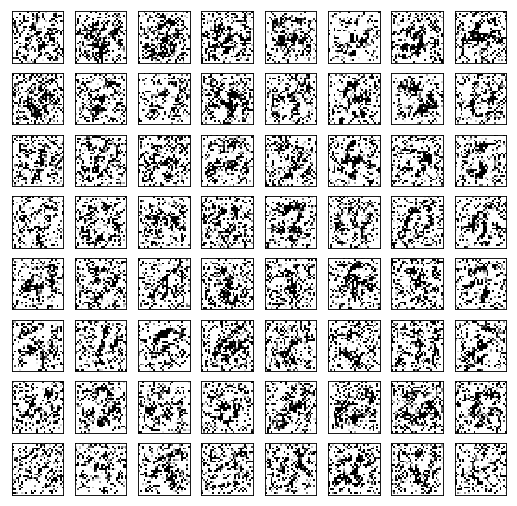

Iteration 162000: loss=0.0008263122872449458
Iteration 164000: loss=0.0008263117051683366
Iteration 166000: loss=0.0008263117051683366
Iteration 168000: loss=0.0008263111812993884
Iteration 170000: loss=0.0008263108902610838
Iteration 172000: loss=0.0008263106574304402
Iteration 174000: loss=0.0008263103663921356
Iteration 176000: loss=0.0008263099007308483
Iteration 178000: loss=0.0008263100171461701
Iteration 180000: loss=0.0008263097843155265
Iteration 182000: loss=0.000826309435069561
Iteration 184000: loss=0.000826309435069561
Iteration 186000: loss=0.0008263089694082737
Iteration 188000: loss=0.0008263084455393255
Iteration 190000: loss=0.00082630809629336
Iteration 192000: loss=0.0008263082127086818
Iteration 194000: loss=0.0008263076306320727
Iteration 196000: loss=0.0008263076888397336
Iteration 198000: loss=0.0008263071649707854
Iteration 200000: loss=0.0008258014568127692


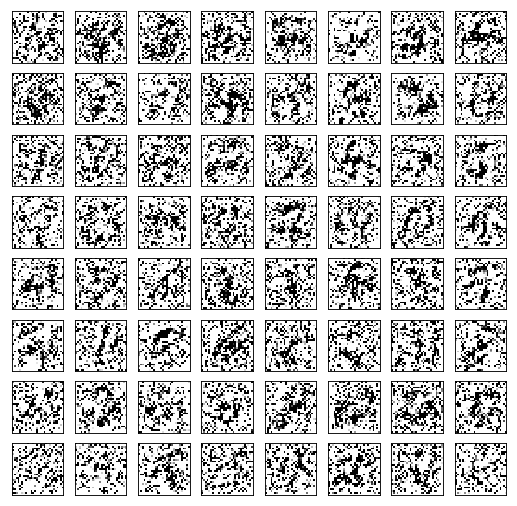

Iteration 202000: loss=0.0008257996523752809
Iteration 204000: loss=0.0008257990702986717
Iteration 206000: loss=0.0008257934241555631
Iteration 208000: loss=0.0008257931913249195
Iteration 210000: loss=0.0008257924346253276
Iteration 212000: loss=0.0008257923764176667
Iteration 214000: loss=0.0008257922017946839
Iteration 216000: loss=0.0008257923182100058
Iteration 218000: loss=0.0008257923182100058
Iteration 220000: loss=0.0008257920853793621
Iteration 222000: loss=0.000825792143587023
Iteration 224000: loss=0.0008257917361333966
Iteration 226000: loss=0.0008257916779257357
Iteration 228000: loss=0.0008257915615104139
Iteration 230000: loss=0.0008257916779257357
Iteration 232000: loss=0.0008257911540567875
Iteration 234000: loss=0.0008257911540567875
Iteration 236000: loss=0.0008257910376414657
Iteration 238000: loss=0.0008257904555648565
Iteration 240000: loss=0.0008257759036496282


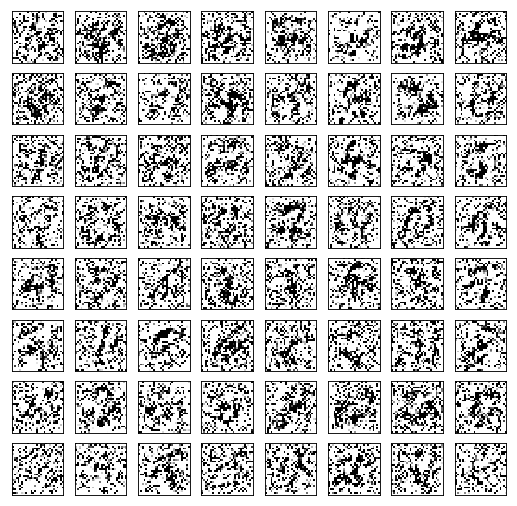

Iteration 242000: loss=0.0008256916771642864
Iteration 244000: loss=0.0008256909204646945
Iteration 246000: loss=0.0008256907458417118
Iteration 248000: loss=0.0008256903965957463
Iteration 250000: loss=0.0008256899891421199
Iteration 252000: loss=0.0008256779983639717
Iteration 254000: loss=0.0008256386499851942
Iteration 256000: loss=0.0008256384171545506
Iteration 258000: loss=0.0008256382425315678
Iteration 260000: loss=0.0008256379514932632
Iteration 262000: loss=0.0008256380097009242
Iteration 264000: loss=0.0008256378350779414
Iteration 266000: loss=0.0008256378932856023
Iteration 268000: loss=0.0008256378932856023
Iteration 270000: loss=0.0008256380679085851
Loss is rising .. stop


In [42]:
new_image_batch = generate_image(img)

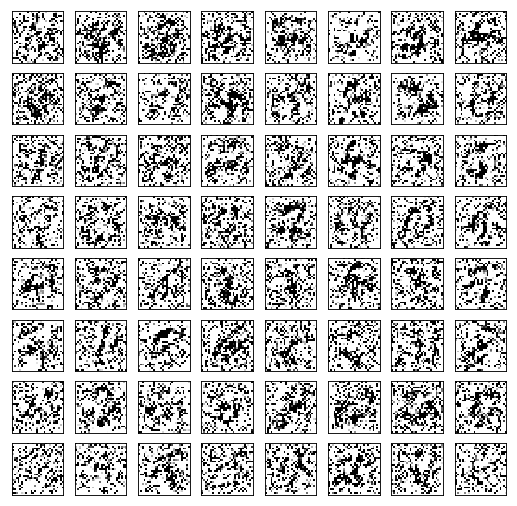

In [43]:
to_plot = new_image_batch.view(-1, 1, 28, 28).clamp(0, 1).data.numpy()
plot_mnist(to_plot, (8, 8))

Преобразуем сгенерированные изображения с помощью энкодера - на выходе получается матрица, близкая к единичной.

In [45]:
latent = model.E(new_image_batch.view(-1, 28*28))
print (latent.shape)
print (latent)

torch.Size([64, 64])
tensor([[ 0.8630,  0.0034,  0.0131,  ...,  0.0025,  0.0253,  0.0191],
        [ 0.0049,  0.9331,  0.0218,  ...,  0.0035,  0.0031,  0.0007],
        [ 0.0023,  0.0406,  0.8976,  ...,  0.0022,  0.0013,  0.0008],
        ...,
        [ 0.0039,  0.0094,  0.0067,  ...,  0.8556,  0.0163,  0.0019],
        [ 0.0182,  0.0065,  0.0042,  ...,  0.0242,  0.8592,  0.0021],
        [ 0.0428,  0.0054,  0.0050,  ...,  0.0065,  0.0040,  0.8595]])


Сравним сгенерированные изображения с выходом декодера

tensor([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1])


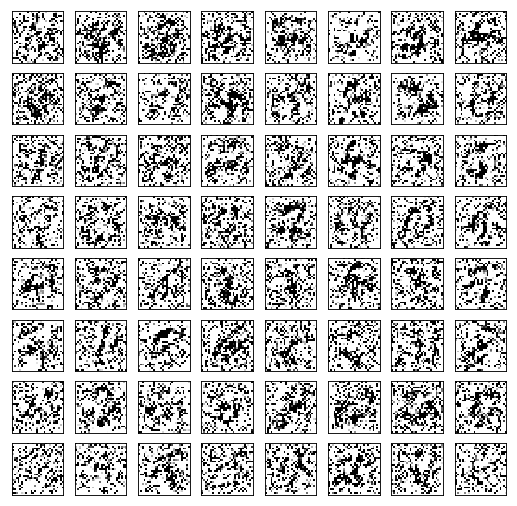

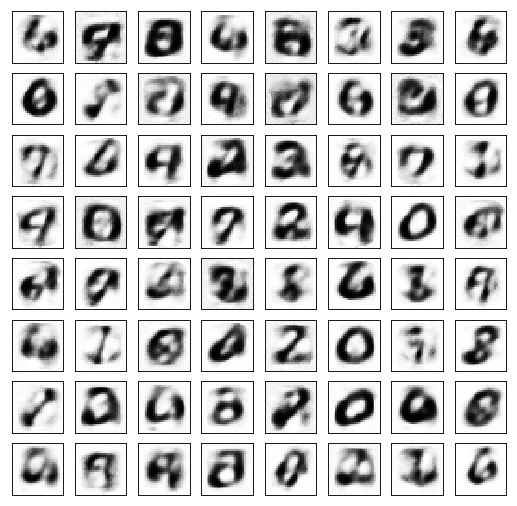

In [51]:
to_plot = new_image_batch.view(-1, 1, 28, 28).clamp(0, 1).data.numpy()

with torch.no_grad():
    encoded = model.E(new_image_batch.view(-1, 28*28))
    print((encoded > 0.2).sum(1))
    encoded[encoded < 0.2] = 0.
    decoded_f = model.decode(encoded)
    f_to_plot = ((decoded_f.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.numpy()

plot_mnist(to_plot, (8, 8))
plot_mnist(f_to_plot, (8, 8))    

### Генерация изображений из случайного шума

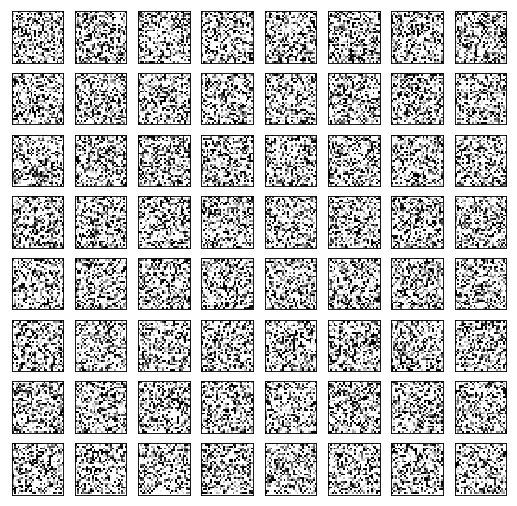

In [46]:
img = torch.randn(64, 784) 
to_plot = img.view(-1, 1, 28, 28).clamp(0, 1).data.numpy()
plot_mnist(to_plot, (8, 8))

Iteration 2000: loss=0.0012087100185453892
Iteration 4000: loss=0.000952726521063596
Iteration 6000: loss=0.0008735416340641677
Iteration 8000: loss=0.0008441171376034617
Iteration 10000: loss=0.0008316175662912428
Iteration 12000: loss=0.0008268803358078003
Iteration 14000: loss=0.0008237944566644728
Iteration 16000: loss=0.0008225817000493407
Iteration 18000: loss=0.0008220598101615906
Iteration 20000: loss=0.0008214075351133943
Iteration 22000: loss=0.0008212460670620203
Iteration 24000: loss=0.0008210270898416638
Iteration 26000: loss=0.0008206904749386013
Iteration 28000: loss=0.0008182771853171289
Iteration 30000: loss=0.0008182234596461058
Iteration 32000: loss=0.0008181786979548633
Iteration 34000: loss=0.0008179444121196866
Iteration 36000: loss=0.0008179016876965761
Iteration 38000: loss=0.000817777297925204
Iteration 40000: loss=0.0008177627460099757


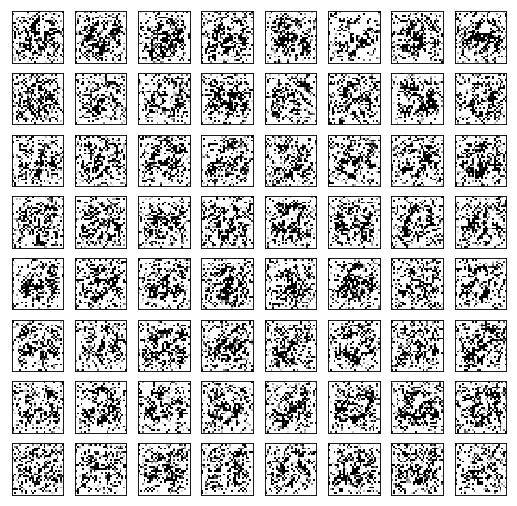

Iteration 42000: loss=0.0008177533745765686
Iteration 44000: loss=0.0008177452837117016
Iteration 46000: loss=0.0008177387062460184
Iteration 48000: loss=0.0008177334675565362
Iteration 50000: loss=0.0008177260751836002
Iteration 52000: loss=0.0008176823612302542
Iteration 54000: loss=0.0008165863109752536
Iteration 56000: loss=0.0008165806066244841
Iteration 58000: loss=0.0008165701292455196
Iteration 60000: loss=0.000816566520370543
Iteration 62000: loss=0.000816561805550009
Iteration 64000: loss=0.0008165573235601187
Iteration 66000: loss=0.0008165487088263035
Iteration 68000: loss=0.0008165364270098507
Iteration 70000: loss=0.0008165345061570406
Iteration 72000: loss=0.0008165326435118914
Iteration 74000: loss=0.0008162013255059719
Iteration 76000: loss=0.0008161867735907435
Iteration 78000: loss=0.0008161563309840858
Iteration 80000: loss=0.0008161516743712127


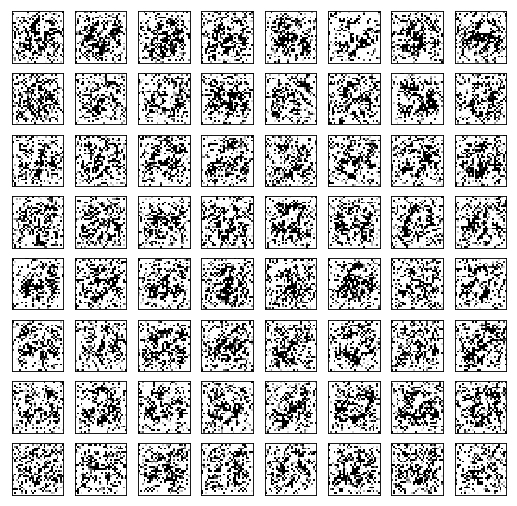

Iteration 82000: loss=0.0008161496953107417
Iteration 84000: loss=0.0008161473670043051
Iteration 86000: loss=0.0008161459118127823
Iteration 88000: loss=0.0008161425357684493
Iteration 90000: loss=0.0008161394507624209
Iteration 92000: loss=0.0008161363657563925
Iteration 94000: loss=0.0008155867108143866
Iteration 96000: loss=0.0008155725663527846
Iteration 98000: loss=0.0008155704126693308
Iteration 100000: loss=0.0008155687246471643
Iteration 102000: loss=0.0008155680843628943
Iteration 104000: loss=0.0008155670948326588
Iteration 106000: loss=0.0008155659888871014
Iteration 108000: loss=0.0008155649993568659
Iteration 110000: loss=0.0008155641844496131
Iteration 112000: loss=0.000814987113699317
Iteration 114000: loss=0.0008149794884957373
Iteration 116000: loss=0.0008149775094352663
Iteration 118000: loss=0.0008149765781126916
Iteration 120000: loss=0.0008149760542437434


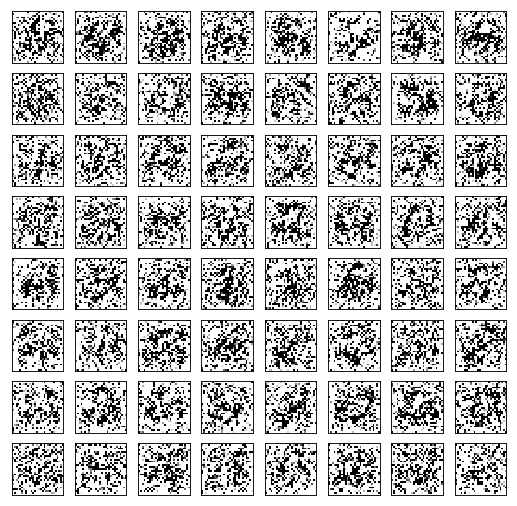

Iteration 122000: loss=0.0008149755885824561
Iteration 124000: loss=0.0008149748318828642
Iteration 126000: loss=0.0008149738423526287
Iteration 128000: loss=0.0008149733184836805
Iteration 130000: loss=0.0008149728528223932
Iteration 132000: loss=0.0008149722125381231
Iteration 134000: loss=0.0008149715140461922
Iteration 136000: loss=0.0008149708737619221
Iteration 138000: loss=0.0008149710483849049
Iteration 140000: loss=0.000814970291685313
Iteration 142000: loss=0.0008149698260240257
Iteration 144000: loss=0.0008149687782861292
Iteration 146000: loss=0.0008149684290401638
Iteration 148000: loss=0.0008149678469635546
Iteration 150000: loss=0.00081496755592525
Iteration 152000: loss=0.0008149674977175891
Iteration 154000: loss=0.00081496627535671
Iteration 156000: loss=0.0008149659261107445
Iteration 158000: loss=0.0008149652858264744
Iteration 160000: loss=0.0008149651694111526


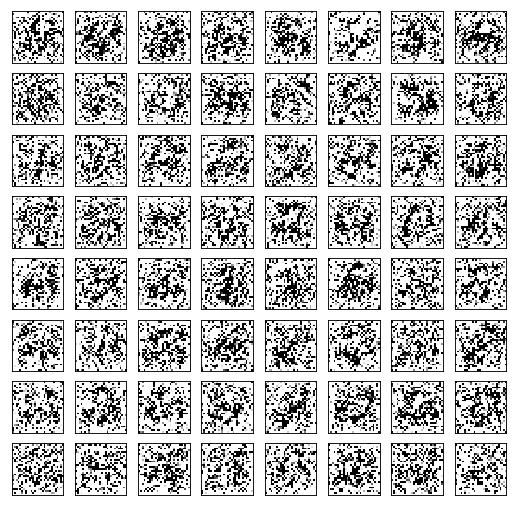

Iteration 162000: loss=0.0008149648201651871
Iteration 164000: loss=0.0008149647619575262
Iteration 166000: loss=0.0008149640634655952
Iteration 168000: loss=0.0008149624918587506
Iteration 170000: loss=0.0008149569621309638
Iteration 172000: loss=0.00081495416816324
Iteration 174000: loss=0.000814913131762296
Iteration 176000: loss=0.000814912433270365
Iteration 178000: loss=0.0008149121422320604
Iteration 180000: loss=0.000814912433270365
Iteration 182000: loss=0.0008149120258167386
Iteration 184000: loss=0.0008149119094014168
Iteration 186000: loss=0.000814911734778434
Iteration 188000: loss=0.000814911094494164
Iteration 190000: loss=0.0008149102795869112
Iteration 192000: loss=0.0008149098139256239
Iteration 194000: loss=0.0008148839115165174
Iteration 196000: loss=0.0008148825145326555
Iteration 198000: loss=0.00081488216528669
Iteration 200000: loss=0.0008148811175487936


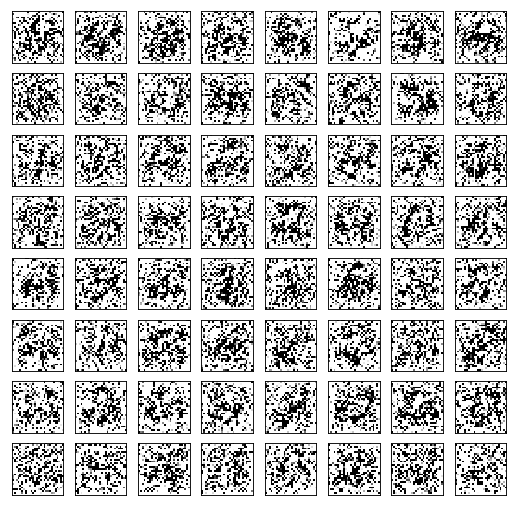

Iteration 202000: loss=0.0008148810593411326
Iteration 204000: loss=0.0008148807100951672
Iteration 206000: loss=0.0008148810011334717
Iteration 208000: loss=0.0008148782071657479
Iteration 210000: loss=0.000814873434137553
Iteration 212000: loss=0.0008148732013069093
Iteration 214000: loss=0.0008148729102686048
Iteration 216000: loss=0.0008148716297000647
Iteration 218000: loss=0.000814871396869421
Iteration 220000: loss=0.0008148713386617601
Iteration 222000: loss=0.0008148711640387774
Iteration 224000: loss=0.0008148711058311164
Iteration 226000: loss=0.0008148706401698291
Iteration 228000: loss=0.0008148704073391855
Iteration 230000: loss=0.0008148704073391855
Iteration 232000: loss=0.0008148705237545073
Loss is rising .. stop


In [47]:
new_image_randn = generate_image(img)

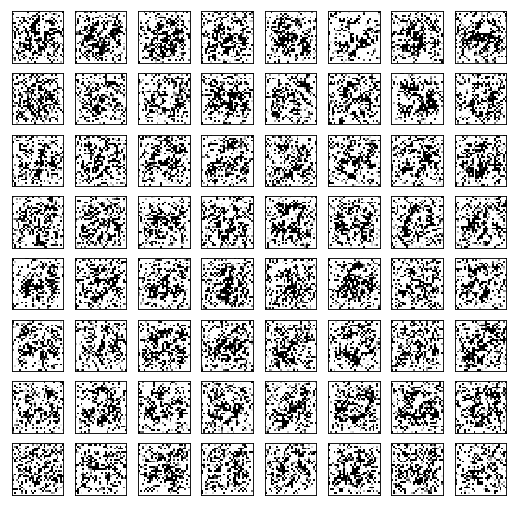

In [48]:
to_plot = new_image_randn.view(-1, 1, 28, 28).clamp(0, 1).data.numpy()
plot_mnist(to_plot, (8, 8))

Преобразуем сгенерированные изображения с помощью энкодера - на выходе получается матрица, близкая к единичной.

In [50]:
latent = model.E(new_image_randn.view(-1, 28*28))
print (latent.shape)
print (latent)

torch.Size([64, 64])
tensor([[ 0.8579,  0.0095,  0.0081,  ...,  0.0018,  0.0304,  0.0206],
        [ 0.0053,  0.9328,  0.0220,  ...,  0.0036,  0.0034,  0.0006],
        [ 0.0023,  0.0406,  0.8976,  ...,  0.0022,  0.0013,  0.0008],
        ...,
        [ 0.0042,  0.0163,  0.0064,  ...,  0.8611,  0.0166,  0.0016],
        [ 0.0243,  0.0105,  0.0043,  ...,  0.0241,  0.8704,  0.0030],
        [ 0.0468,  0.0047,  0.0047,  ...,  0.0075,  0.0062,  0.8506]])


Сравним сгенерированные изображения с выходом декодера

tensor([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1])


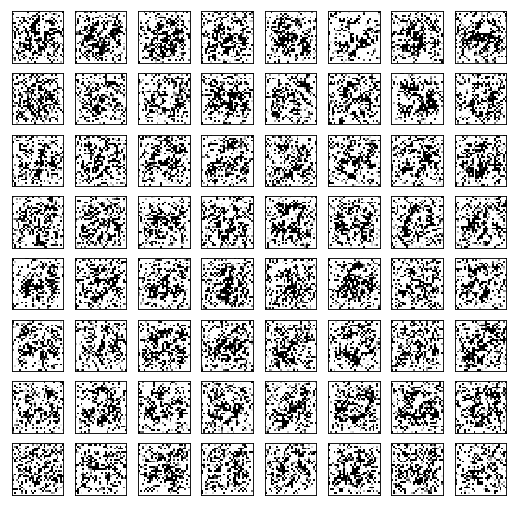

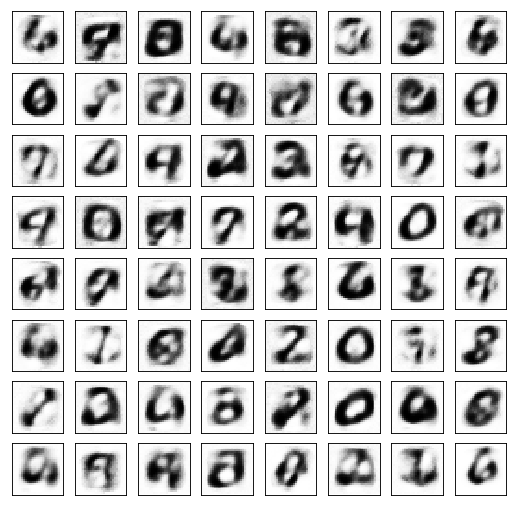

In [52]:
to_plot = new_image_randn.view(-1, 1, 28, 28).clamp(0, 1).data.numpy()

with torch.no_grad():
    encoded = model.E(new_image_randn.view(-1, 28*28))
    print((encoded > 0.2).sum(1))
    encoded[encoded < 0.2] = 0.
    decoded_f = model.decode(encoded)
    f_to_plot = ((decoded_f.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.numpy()

plot_mnist(to_plot, (8, 8))
plot_mnist(f_to_plot, (8, 8)) 

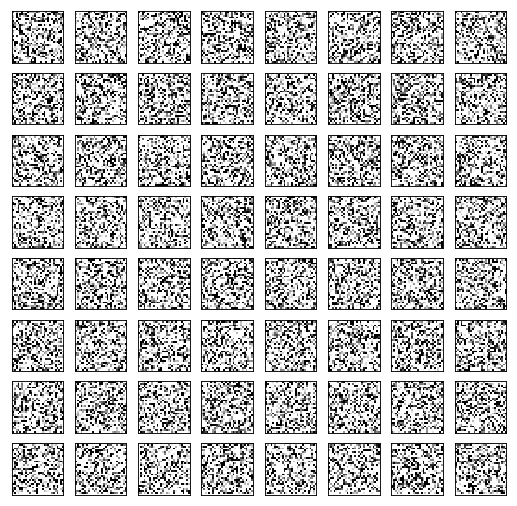

In [53]:
img = torch.randn(64, 784) 
to_plot = img.view(-1, 1, 28, 28).clamp(0, 1).data.numpy()
plot_mnist(to_plot, (8, 8))

Iteration 2000: loss=0.0011964556761085987
Iteration 4000: loss=0.0009450134821236134
Iteration 6000: loss=0.0008676235447637737
Iteration 8000: loss=0.0008411139715462923
Iteration 10000: loss=0.0008300982299260795
Iteration 12000: loss=0.0008239363087341189
Iteration 14000: loss=0.000821140652988106
Iteration 16000: loss=0.0008181665325537324
Iteration 18000: loss=0.000817426189314574
Iteration 20000: loss=0.0008168601780198514
Iteration 22000: loss=0.0008167180931195617
Iteration 24000: loss=0.0008166484185494483
Iteration 26000: loss=0.0008165701874531806
Iteration 28000: loss=0.0008165129693225026
Iteration 30000: loss=0.0008164876489900053
Iteration 32000: loss=0.0008160885190591216
Iteration 34000: loss=0.0008160665165632963
Iteration 36000: loss=0.00081459159264341
Iteration 38000: loss=0.0008145464234985411
Iteration 40000: loss=0.0008144218591041863


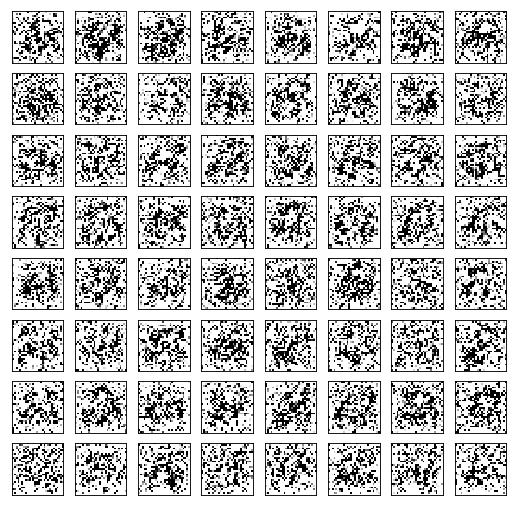

Iteration 42000: loss=0.0008143988088704646
Iteration 44000: loss=0.0008143821614794433
Iteration 46000: loss=0.0008143442100845277
Iteration 48000: loss=0.0008143080049194396
Iteration 50000: loss=0.0008143013110384345
Iteration 52000: loss=0.0008141595171764493
Iteration 54000: loss=0.0008140932768583298
Iteration 56000: loss=0.0008140851859934628
Iteration 58000: loss=0.0008140529389493167
Iteration 60000: loss=0.0008137672557495534
Iteration 62000: loss=0.0008129985071718693
Iteration 64000: loss=0.0008129682391881943
Iteration 66000: loss=0.0008129644556902349
Iteration 68000: loss=0.0008129611378535628
Iteration 70000: loss=0.0008129581692628562
Iteration 72000: loss=0.0008129561319947243
Iteration 74000: loss=0.0008129535708576441
Iteration 76000: loss=0.0008129434427246451
Iteration 78000: loss=0.0008129411144182086
Iteration 80000: loss=0.0008129399502649903


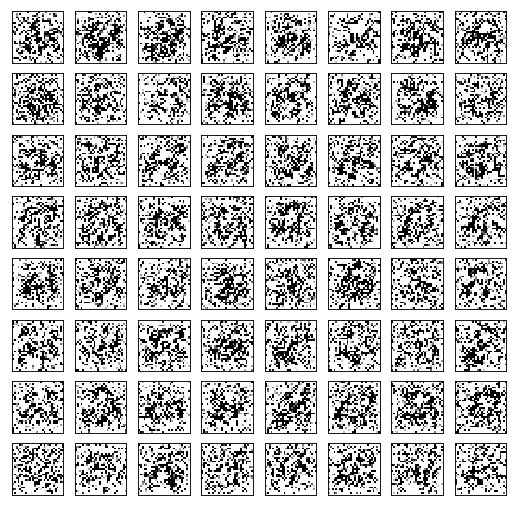

Iteration 82000: loss=0.0008129318594001234
Iteration 84000: loss=0.0008129026391543448
Iteration 86000: loss=0.0008129006600938737
Iteration 88000: loss=0.0008128987974487245
Iteration 90000: loss=0.0008128967601805925
Iteration 92000: loss=0.0008128936169669032
Iteration 94000: loss=0.0008128919289447367
Iteration 96000: loss=0.0008128585759550333
Iteration 98000: loss=0.0008128578192554414
Iteration 100000: loss=0.0008128564222715795
Iteration 102000: loss=0.0008128553163260221
Iteration 104000: loss=0.0008128542685881257
Iteration 106000: loss=0.0008128536865115166
Iteration 108000: loss=0.0008128521149046719
Iteration 110000: loss=0.0008128510671667755
Iteration 112000: loss=0.0008128500776365399
Iteration 114000: loss=0.0008128491463139653
Iteration 116000: loss=0.0008128483896143734
Iteration 118000: loss=0.0008128475164994597
Iteration 120000: loss=0.0008128082263283432


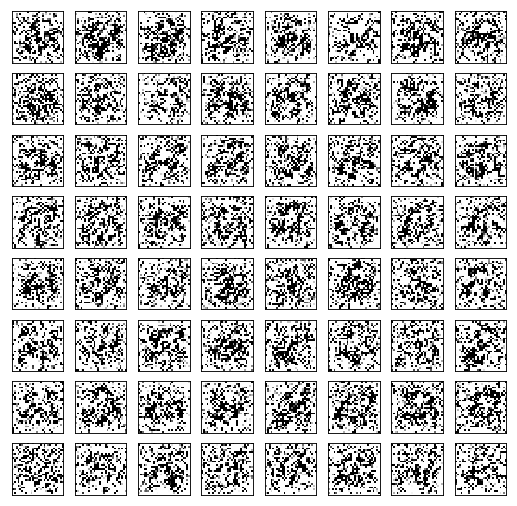

Iteration 122000: loss=0.0008128067129291594
Iteration 124000: loss=0.0008128048502840102
Iteration 126000: loss=0.0008128039189614356
Iteration 128000: loss=0.0008128028130158782
Iteration 130000: loss=0.0008128018234856427
Iteration 132000: loss=0.0008128022309392691
Iteration 134000: loss=0.000812796235550195
Iteration 136000: loss=0.0008127951878122985
Iteration 138000: loss=0.0008127941400744021
Iteration 140000: loss=0.000812793557997793
Iteration 142000: loss=0.0008127923356369138
Iteration 144000: loss=0.0008127395412884653
Iteration 146000: loss=0.0008127387263812125
Iteration 148000: loss=0.0008127380860969424
Iteration 150000: loss=0.0008127377950586379
Iteration 152000: loss=0.0008127372711896896
Iteration 154000: loss=0.000812737038359046
Iteration 156000: loss=0.000812737038359046
Iteration 158000: loss=0.0008127334294840693
Iteration 160000: loss=0.000812733022030443


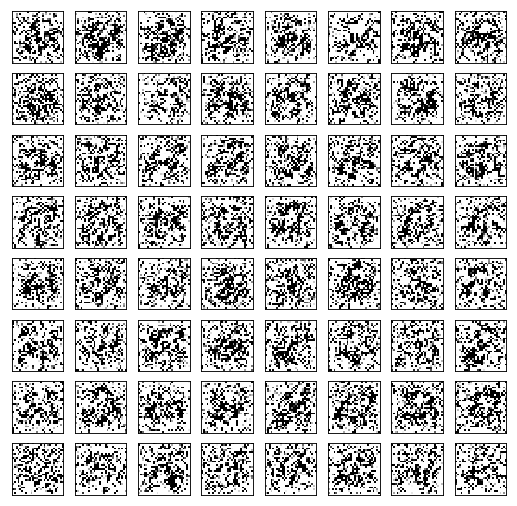

Iteration 162000: loss=0.0008127328474074602
Iteration 164000: loss=0.0008127310429699719
Iteration 166000: loss=0.0008127266773954034
Iteration 168000: loss=0.0008127262117341161
Iteration 170000: loss=0.0008127254550345242
Iteration 172000: loss=0.0008127252222038805
Iteration 174000: loss=0.0008127242908813059
Iteration 176000: loss=0.0008127241744659841
Iteration 178000: loss=0.0008127237670123577
Iteration 180000: loss=0.0008127231849357486
Iteration 182000: loss=0.0008127165492624044
Iteration 184000: loss=0.0008127154433168471
Iteration 186000: loss=0.000812714861240238
Iteration 188000: loss=0.0008127145702019334
Iteration 190000: loss=0.0008127142791636288
Iteration 192000: loss=0.0008127138135023415
Iteration 194000: loss=0.0008127135224640369
Iteration 196000: loss=0.0008127131150104105
Iteration 198000: loss=0.0008127131732180715
Iteration 200000: loss=0.0008127130568027496


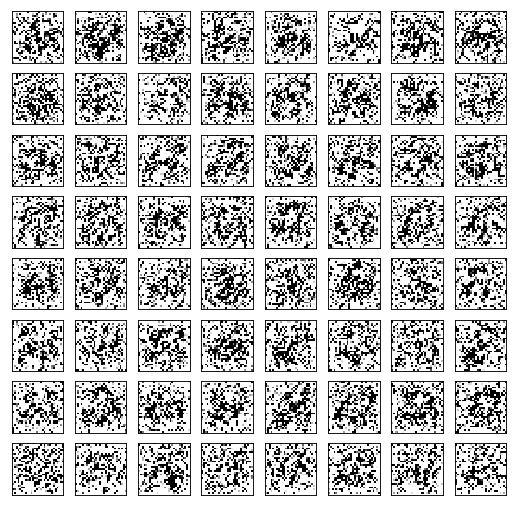

Iteration 202000: loss=0.0008127129985950887
Iteration 204000: loss=0.0008127125911414623
Iteration 206000: loss=0.0008127111359499395
Iteration 208000: loss=0.000812708109151572
Iteration 210000: loss=0.0008127077016979456
Iteration 212000: loss=0.0008127077016979456
Iteration 214000: loss=0.0008127075852826238
Iteration 216000: loss=0.0008127074688673019
Iteration 218000: loss=0.000812707410659641
Iteration 220000: loss=0.0008127069449983537
Iteration 222000: loss=0.0008127069449983537
Iteration 224000: loss=0.0008127070032060146
Loss is rising .. stop


In [54]:
new_image_randn = generate_image(img)

tensor([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1])


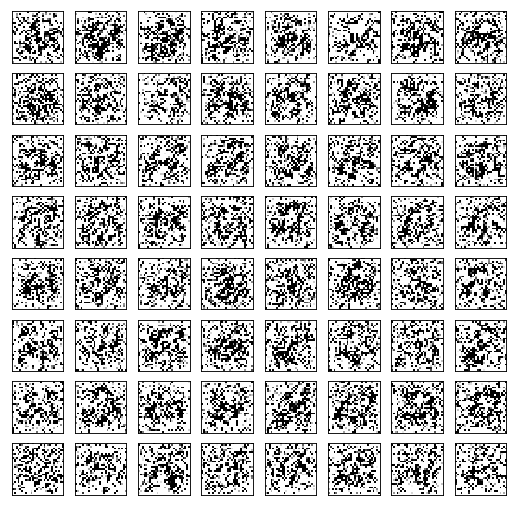

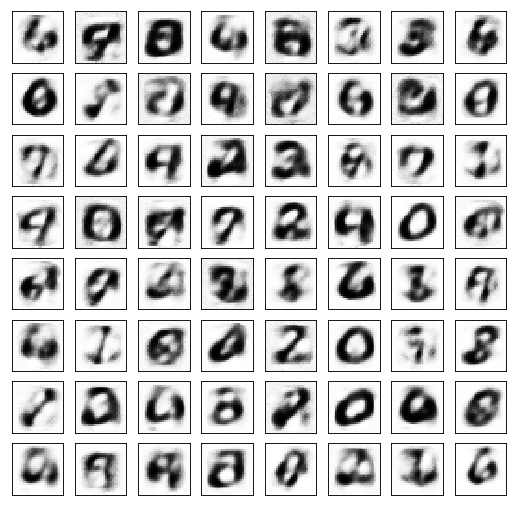

In [55]:
to_plot = new_image_randn.view(-1, 1, 28, 28).clamp(0, 1).data.numpy()

with torch.no_grad():
    encoded = model.E(new_image_randn.view(-1, 28*28))
    print((encoded > 0.2).sum(1))
    encoded[encoded < 0.2] = 0.
    decoded_f = model.decode(encoded)
    f_to_plot = ((decoded_f.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.numpy()

plot_mnist(to_plot, (8, 8))
plot_mnist(f_to_plot, (8, 8)) 